# RetinaNet

This notebook details how the RetinaNet model was trained 4-folds, benchmarked and evaluated

install necessary libraries

In [ ]:
from google.colab import drive
import os
import cv2
import json
import torch
import random
import supervision as sv
import numpy as np
import shutil
from google.colab import runtime
from mmdet.apis import init_detector, inference_detector

installing versions of pytorch and libraries compatible with mmdetection

In [ ]:
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 torchdata==0.6.1 torchtext==0.15.2 fastapi kaleido python-multipart uvicorn lida torchdata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

installing supervision compatible with mmdetection

In [ ]:
!pip install -q supervision==0.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 2.4 MB/s eta 0:00:00


setting the variable HOME to the current working directory by using the os.getcwd() function from Python's os module for easy reference of home directory

In [ ]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


Setting up up the environment for using MMDetection by installing necessary compatible versions of dependencies (mmengine, mmcv, mmdet), cloning the MMDetection repository, and installing it in an editable mode.

In [ ]:
%cd {HOME}

%pip install -U -q openmim


!mim install -q "mmdet>=3.0.0rc6,<3.1.0"


!mim install "mmengine>=0.7.0"
!mim install "mmcv>=2.0.0rc4"


!git clone https://github.com/open-mmlab/mmdetection.git


%cd {HOME}/mmdetection

%pip install -e .

/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 38.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.1/953.1 kB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 16.5 MB/s eta 0:00:00
     ━━━━━━

Mount google drive to access data stored

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


downloading pretrained weights for faster training of the model

In [ ]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r101_fpn_1x_coco/retinanet_r101_fpn_1x_coco_20200130-7a93545f.pth
!ls -lh {HOME}/weights

total 218M
-rw-r--r-- 1 root root 218M Nov  2  2021 retinanet_r101_fpn_1x_coco_20200130-7a93545f.pth


Setting up a custom configuration file for the model which defines

* Configuration Path: Sets the path for saving the custom configuration.
* Base Model: Inherits from a Faster R-CNN config and customizes it for the specific dataset.
* Dataset and DataLoader: Configures paths, batch sizes, and annotations for training, validation, and testing datasets.
* Model Architecture: Tailors the roi_head for a single-class detection task, adjusting bounding box heads and loss functions.
* Learning Rate Scheduling: Implements a two-stage learning rate scheduler with linear warm-up and cosine annealing.
* Training Pipeline: Defines data augmentation for the second training stage.
* Optimizer: Uses AdamW with specific learning rates and weight decay settings.
* Hooks: Includes early stopping, checkpointing, and logging to monitor and optimize the training process.
* Pretrained Weights: Loads COCO-pretrained weight to initialize the model.
* Training Loop: Uses an epoch-based training loop with validation at each epoch.
* Visualization: Configures visualizers, including TensorBoard, for monitoring.

In [ ]:
#1st fold
CUSTOM_CONFIG_PATH = f"{HOME}/mmdetection/configs/retinanet/custom_retinanet.py"

CUSTOM_CONFIG = """
# Inherit and overwrite part of the config based on this config
_base_ = './retinanet_r50_fpn_1x_coco.py'

data_root = '/content/drive/MyDrive/Combined Dataset3/2024-07-07_5-Fold_Cross-val/split_1/'  # Ensure this points to your dataset root

train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 100
base_lr = 0.00008

metainfo = {
    'classes': ('invoice', ),  # Replace 'your_class' with the name of your class
    'palette': [
        (220, 20, 60),
    ]
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/images/'),
        ann_file='train/images/annotations.json',))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='val/images/'),
        ann_file='val/images/annotations.json',))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'val/images/annotations.json')

test_evaluator = val_evaluator

model = dict(
    backbone=dict(
        depth=101,
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet101')),
    bbox_head=dict(
        num_classes=1  # Set the number of classes to 1
    )
)

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    early_stopping=dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        patience=10,
        min_delta=0.01),
    checkpoint=dict(
        type='CheckpointHook',
        interval=5,
        save_begin=1,
        max_keep_ckpts=2,
        save_best='auto'),
    logger=dict(type='LoggerHook', interval=5))

# load COCO pre-trained weight

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])

"""


writing the custom configuration file to the folder

In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

Running training on the custom configuration file

In [ ]:
%cd {HOME}/mmdetection
!python tools/train.py configs/retinanet/custom_retinanet.py

Streaming output truncated to the last 5000 lines.
07/09 13:14:54 - mmengine - INFO - Epoch(train)  [23][400/405]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 8:35:43  time: 0.9549  data_time: 0.0106  memory: 9859  loss: 0.1757  loss_cls: 0.0592  loss_bbox: 0.1165
07/09 13:14:59 - mmengine - INFO - Exp name: custom_retinanet_20240709_102435
07/09 13:14:59 - mmengine - INFO - Epoch(train)  [23][405/405]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 8:35:37  time: 0.9521  data_time: 0.0105  memory: 9858  loss: 0.1760  loss_cls: 0.0592  loss_bbox: 0.1168
07/09 13:14:59 - mmengine - INFO - Epoch(val)  [23][  5/406]    eta: 0:00:30  time: 0.0732  data_time: 0.0030  memory: 906  
07/09 13:15:00 - mmengine - INFO - Epoch(val)  [23][ 10/406]    eta: 0:00:30  time: 0.0737  data_time: 0.0030  memory: 906  
07/09 13:15:00 - mmengine - INFO - Epoch(val)  [23][ 15/406]    eta: 0:00:30  time: 0.0736  data_time: 0.0030  memory: 906  
07/09 13:15:00 - mmengine - INFO - Epoch(val)  [23][ 20/406]    eta: 0:00:

saving training results to a folder

In [ ]:
#saving best run result

# Source and destination paths
source_folder = '/content/mmdetection/work_dirs/custom_retinanet'
destination_folder = '/content/drive/MyDrive/RetinaNet_runs/kfolds/retinanet100epochs-1fold'

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/RetinaNet_runs/kfolds/retinanet100epochs-1fold'

Defining custom configuration file for 2nd fold with checkpoint of the model trained in the previous fold and saving the training result

In [ ]:
#fold 2
#early stopping
CUSTOM_CONFIG_PATH = f"{HOME}/mmdetection/configs/retinanet/custom_retinanet.py"

CUSTOM_CONFIG = """
# Inherit and overwrite part of the config based on this config
_base_ = './retinanet_r50_fpn_1x_coco.py'

data_root = '/content/drive/MyDrive/Combined Dataset3/2024-07-07_5-Fold_Cross-val/split_2/'  # Ensure this points to your dataset root

train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 100
base_lr = 0.00008

metainfo = {
    'classes': ('invoice', ),  # Replace 'your_class' with the name of your class
    'palette': [
        (220, 20, 60),
    ]
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/images/'),
        ann_file='train/images/annotations.json',))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='val/images/'),
        ann_file='val/images/annotations.json',))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'val/images/annotations.json')

test_evaluator = val_evaluator

model = dict(
    backbone=dict(
        depth=101,
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet101')),
    bbox_head=dict(
        num_classes=1  # Set the number of classes to 1
    )
)

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    early_stopping=dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        patience=10,
        min_delta=0.01),
    checkpoint=dict(
        type='CheckpointHook',
        interval=5,
        save_begin=1,
        max_keep_ckpts=2,
        save_best='auto'),
    logger=dict(type='LoggerHook', interval=5))

# load COCO pre-trained weight

load_from = '/content/drive/MyDrive/RetinaNet_runs/kfolds/retinanet100epochs-1fold/epoch_49.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])

"""


In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

In [ ]:
%cd {HOME}/mmdetection
!python tools/train.py configs/retinanet/custom_retinanet.py

/content/mmdetection
07/09 16:53:03 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1565022580
    GPU 0: NVIDIA L4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;a

In [ ]:
#saving best run result

# Source and destination paths
source_folder = '/content/mmdetection/work_dirs/custom_retinanet'
destination_folder = '/content/drive/MyDrive/RetinaNet_runs/kfolds/retinanet100epochs-2fold'

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder)

Defining custom configuration file for 3rd fold with checkpoint of the model trained in the previous fold and saving the training result

In [ ]:
#fold 3
#early stopping
CUSTOM_CONFIG_PATH = f"{HOME}/mmdetection/configs/retinanet/custom_retinanet.py"

CUSTOM_CONFIG = """
# Inherit and overwrite part of the config based on this config
_base_ = './retinanet_r50_fpn_1x_coco.py'

data_root = '/content/drive/MyDrive/Combined Dataset3/2024-07-07_5-Fold_Cross-val/split_3/'  # Ensure this points to your dataset root

train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 100
base_lr = 0.00008

metainfo = {
    'classes': ('invoice', ),  # Replace 'your_class' with the name of your class
    'palette': [
        (220, 20, 60),
    ]
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/images/'),
        ann_file='train/images/annotations.json',))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='val/images/'),
        ann_file='val/images/annotations.json',))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'val/images/annotations.json')

test_evaluator = val_evaluator

model = dict(
    backbone=dict(
        depth=101,
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet101')),
    bbox_head=dict(
        num_classes=1  # Set the number of classes to 1
    )
)

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    early_stopping=dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        patience=10,
        min_delta=0.01),
    checkpoint=dict(
        type='CheckpointHook',
        interval=5,
        save_begin=1,
        max_keep_ckpts=2,
        save_best='auto'),
    logger=dict(type='LoggerHook', interval=5))

# load COCO pre-trained weight

load_from = '/content/drive/MyDrive/RetinaNet_runs/kfolds/retinanet100epochs-2fold/epoch_11.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])

"""


In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

In [ ]:
%cd {HOME}/mmdetection
!python tools/train.py configs/retinanet/custom_retinanet.py

/content/mmdetection
07/09 18:59:16 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 715969278
    GPU 0: NVIDIA L4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;ar

In [ ]:
#saving best run result

# Source and destination paths
source_folder = '/content/mmdetection/work_dirs/custom_retinanet'
destination_folder = '/content/drive/MyDrive/RetinaNet_runs/kfolds/retinanet100epochs-3fold'

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/RetinaNet_runs/kfolds/retinanet100epochs-3fold'

Defining a custom configuration file for the 4th fold, incorporating rotation augmentation to improve performance on detecting rotated images, using the checkpoint from the model trained in the previous fold, and saving the training results.

In [ ]:
#fold 4
#rotations
CUSTOM_CONFIG_PATH = f"{HOME}/mmdetection/configs/retinanet/custom_retinanet.py"

CUSTOM_CONFIG = """
# Inherit and overwrite part of the config based on this config
_base_ = './retinanet_r50_fpn_1x_coco.py'

data_root = '/content/drive/MyDrive/Combined Dataset3/2024-07-07_5-Fold_Cross-val/split_4/'  # Ensure this points to your dataset root

train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 100
base_lr = 0.00008

metainfo = {
    'classes': ('invoice', ),  # Replace 'your_class' with the name of your class
    'palette': [
        (220, 20, 60),
    ]
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/images/'),
        ann_file='train/images/annotations.json',))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='val/images/'),
        ann_file='val/images/annotations.json',))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'val/images/annotations.json')

test_evaluator = val_evaluator

model = dict(
    backbone=dict(
        depth=101,
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet101')),
    bbox_head=dict(
        num_classes=1  # Set the number of classes to 1
    )
)

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

train_pipeline = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RandomRotate', angle_range=(-100, 100), prob=0.5),  # Adding random rotation
    dict(type='YOLOXHSVRandomAug'),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]

train_pipeline_stage2 = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RandomRotate', angle_range=(-100, 100), prob=0.5),  # Adding random rotation
    dict(type='YOLOXHSVRandomAug'),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]


# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    early_stopping=dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        patience=10,
        min_delta=0.01),
    checkpoint=dict(
        type='CheckpointHook',
        interval=5,
        save_begin=1,
        max_keep_ckpts=2,
        save_best='auto'),
    logger=dict(type='LoggerHook', interval=5))

# load COCO pre-trained weight

load_from = '/content/drive/MyDrive/RetinaNet_runs/kfolds/retinanet100epochs-3fold/epoch_11.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])

"""


In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

In [ ]:
%cd {HOME}/mmdetection
!python tools/train.py configs/retinanet/custom_retinanet.py

/content/mmdetection
07/15 10:31:36 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 598129083
    GPU 0: NVIDIA L4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;ar

In [ ]:
#saving best run result

# Source and destination paths
source_folder = '/content/mmdetection/work_dirs/custom_retinanet'
destination_folder = '/content/drive/MyDrive/RetinaNet_runs/kfolds/retinanet100epochs-4fold'

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/RetinaNet_runs/kfolds/retinanet100epochs-4fold'

Command to disconnect runtime after training

In [ ]:
runtime.unassign()

# Benchmarking

Code to calculate memory usage of the model

In [ ]:
!python tools/analysis_tools/benchmark.py configs/retinanet/custom_retinanet.py --checkpoint /content/drive/MyDrive/RetinaNet_runs/kfolds/retinanet100epochs-4fold/epoch_6.pth --dataset-type val --fuse-conv-bn

/content/mmdetection
07/15 19:24:05 - mmengine - INFO - before build: 
07/15 19:24:05 - mmengine - INFO - (GB) mem_used: 1.66 | uss: 0.32 | pss: 0.40 | total_proc: 1
loading annotations into memory...
Done (t=3.84s)
creating index...
index created!
07/15 19:24:11 - mmengine - INFO - after build: 
07/15 19:24:11 - mmengine - INFO - (GB) mem_used: 1.76 | uss: 0.37 | pss: 0.45 | total_proc: 1
07/15 19:24:21 - mmengine - INFO - ==================================
07/15 19:24:21 - mmengine - INFO - Done batch [50 /2000], fps: 4.8 batch/s, times per batch: 206.6 ms/batch, batch size: 1, num_workers: 2
07/15 19:24:21 - mmengine - INFO - (GB) mem_used: 1.84 | uss: 0.13 | pss: 0.53 | total_proc: 3
07/15 19:24:33 - mmengine - INFO - ==================================
07/15 19:24:33 - mmengine - INFO - Done batch [100/2000], fps: 4.6 batch/s, times per batch: 215.9 ms/batch, batch size: 1, num_workers: 2
07/15 19:24:33 - mmengine - INFO - (GB) mem_used: 1.84 | uss: 0.18 | pss: 0.57 | total_proc: 3

# Evaluation

Code to calculate performance metrics like recall, mAP50, mAP75 and mAP50-95

In [ ]:
!python tools/test.py configs/retinanet/custom_retinanet.py '/content/drive/MyDrive/RetinaNet_runs/kfolds/retinanet100epochs-4fold/epoch_6.pth' --out results.pkl

07/15 19:34:45 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
    CUDA available: False
    MUSA available: False
    numpy_random_seed: 151646028
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.7, CUDNN_VERSION=8.5.0, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_USE_CXX11_ABI=0 -fabi-v

---
# Experimentation Codes


This section contains pieces of code used for testing or experimenting

Without k-fold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 torchdata==0.6.1 torchtext==0.15.2 fastapi kaleido python-multipart uvicorn lida torchdata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 108.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%cd {HOME}

%pip install -U -q openmim


!mim install -q "mmdet>=3.0.0rc6,<3.1.0"


!mim install "mmengine>=0.7.0"
!mim install "mmcv>=2.0.0rc4"


!git clone https://github.com/open-mmlab/mmdetection.git


%cd {HOME}/mmdetection

%pip install -e .

/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.4/307.4 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 34.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.1/953.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
!pip install -q supervision==0.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 2.5 MB/s eta 0:00:00


In [ ]:
import cv2
import os
import json
import torch
import random
import supervision as sv
import numpy as np

In [ ]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r101_fpn_1x_coco/retinanet_r101_fpn_1x_coco_20200130-7a93545f.pth
!ls -lh {HOME}/weights

total 218M
-rw-r--r-- 1 root root 218M Nov  2  2021 retinanet_r101_fpn_1x_coco_20200130-7a93545f.pth


In [ ]:
BATCH_SIZE = 8
MAX_EPOCHS = 50

In [ ]:
#early stopping
CUSTOM_CONFIG_PATH = f"{HOME}/mmdetection/configs/retinanet/custom_retinanet.py"

CUSTOM_CONFIG = """
# Inherit and overwrite part of the config based on this config
_base_ = './retinanet_r50_fpn_1x_coco.py'

data_root = '/content/drive/MyDrive/Combined Dataset2/'  # Ensure this points to your dataset root

train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 200
base_lr = 0.00008

metainfo = {
    'classes': ('invoice', ),  # Replace 'your_class' with the name of your class
    'palette': [
        (220, 20, 60),
    ]
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/images/'),
        ann_file='train/images/annotations.json',))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='valid/images/'),
        ann_file='valid/images/annotations.json',))

test_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='test/images/'),
        ann_file='test/images/annotations.json',))

val_evaluator = dict(ann_file=data_root + 'valid/images/annotations.json')

test_evaluator = dict(ann_file=data_root + 'test/images/annotations.json')

model = dict(
    backbone=dict(
        depth=101,
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet101')),
    bbox_head=dict(
        num_classes=1  # Set the number of classes to 1
    )
)

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    early_stopping=dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        patience=10,
        min_delta=0.01),
    checkpoint=dict(
        type='CheckpointHook',
        interval=5,
        save_begin=1,
        max_keep_ckpts=2,
        save_best='auto'),
    logger=dict(type='LoggerHook', interval=5))

# load COCO pre-trained weight
load_from = '/content/weights/retinanet_r101_fpn_1x_coco_20200130-7a93545f.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])

"""


In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

In [ ]:
%cd {HOME}/mmdetection
!python tools/train.py configs/retinanet/custom_retinanet.py

/content/mmdetection
06/26 09:05:41 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1121426542
    GPU 0: NVIDIA L4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;a

In [ ]:
#saving best run result
import shutil

# Source and destination paths
source_folder = '/content/mmdetection/work_dirs/custom_retinanet'
destination_folder = '/content/drive/MyDrive/RetinaNet_runs/retinanet200epochs-no early stopping'

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/RetinaNet_runs/retinanet200epochs-no early stopping'

In [ ]:
from mmdet.apis import init_detector, inference_detector

In [ ]:
CUSTOM_WEIGHTS_PATH = "/content/drive/MyDrive/RetinaNet_runs/retinanet200epochs-no early stopping/epoch_23.pth"

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = init_detector(CUSTOM_CONFIG_PATH, CUSTOM_WEIGHTS_PATH, device=DEVICE)

Loads checkpoint by local backend from path: /content/drive/MyDrive/RetinaNet_runs/retinanet200epochs-no early stopping/epoch_23.pth


In [ ]:
evaluation = dict(interval=1, metric=['bbox'], save_best='bbox_mAP_50')

In [ ]:
!python tools/test.py '/content/mmdetection/configs/dynamic_rcnn/custom_dynamic_rcnn.py' '/content/drive/MyDrive/Dynamic_R_CNN_runs/dynamicrcnn150epochs-best26/epoch_26.pth' --out results.pkl

06/26 08:05:30 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: False
    MUSA available: False
    numpy_random_seed: 1503303189
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.7, CUDNN_VERSION=8.5.0, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_USE_CXX11_ABI=0 -fabi-

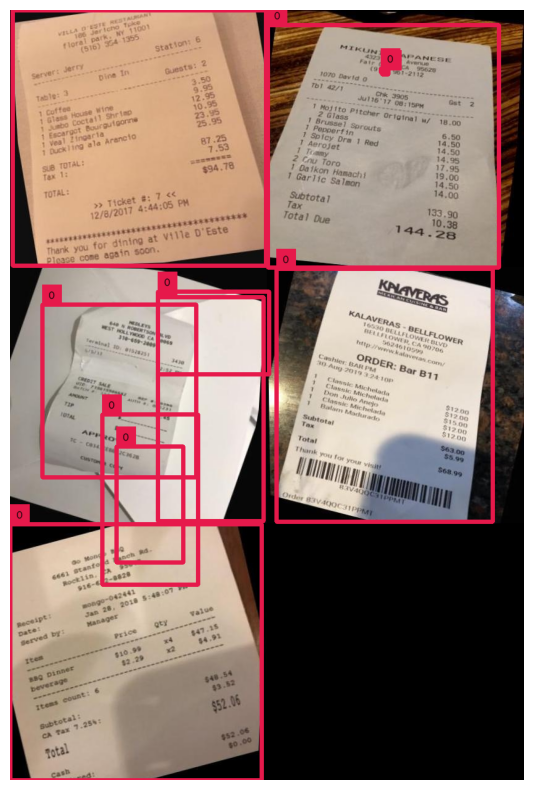

In [ ]:
IMAGE_PATH = "/content/WhatsApp Image 2024-06-23 at 18.22.11_69c2283c.jpg"
image = cv2.imread(IMAGE_PATH)
result = inference_detector(model, image)

detections = sv.Detections.from_mmdetection(result)
box_annotator = sv.BoxAnnotator(thickness=5)
annotated_image = box_annotator.annotate(image.copy(), detections)
sv.plot_image(image=annotated_image, size=(10, 10))

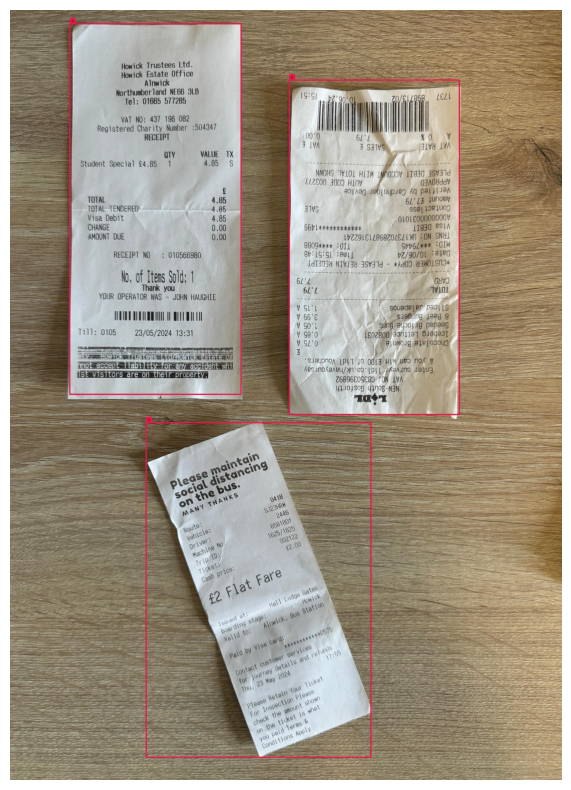

In [ ]:
IMAGE_PATH = "/content/WhatsApp Image 2024-06-23 at 18.22.11_69c2283c.jpg"
image = cv2.imread(IMAGE_PATH)
result = inference_detector(model, image)
detections = sv.Detections.from_mmdetection(result)
detections = detections[detections.confidence > 0.4].with_nms()

box_annotator = sv.BoxAnnotator(thickness=5)
annotated_image = box_annotator.annotate(image.copy(), detections)
sv.plot_image(image=annotated_image, size=(10, 10))